# ETL Pipeline

This notebook does the following:
* Takes in all scanned documents as .pdf files
* Converts each page to a image
* Uses homograpghy to orient them based on a template of a blank form

### Import Dependencies

In [1]:
import os
import pdf2image
from matplotlib import pyplot as plt
import imutils
import cv2
import numpy as np

### Extract images from pdfs

* Locates all pdf files
* Extracts each page as an image
* Stores all images in a list for homography
* Shows an example of loaded documents

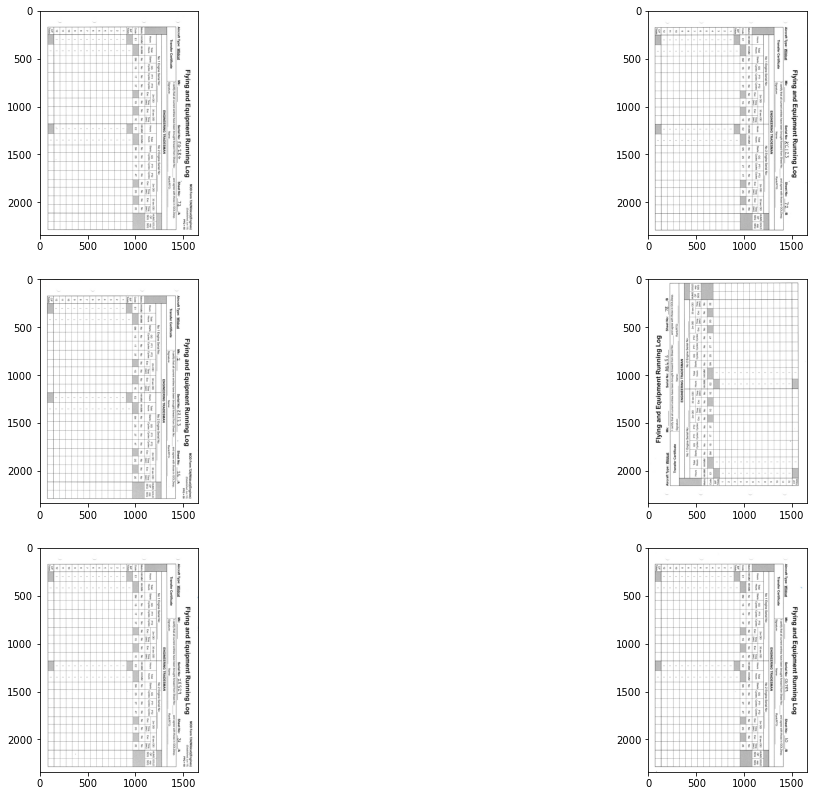

In [2]:
#directory of stored pdf files
path = "C:\\GitHub\\mf724-ocr\\724_scans\\"
#extract all files from path
pdfs = os.listdir(path)
#empty list to store extracted images
forms = []

#iterate through all pdf files
for pdf in pdfs:
    filepath = r"{}".format(path + "\\" + pdf)
    #use pdf2image and poppler to convert pages into images
    pages = pdf2image.convert_from_path(filepath, poppler_path = r"C:\Program Files\poppler-21.03.0\Library\bin")
    #iterate through extracted pages
    for page in pages:
        #temporarily save files then 
        page.save("temp.jpg", "jpeg")
        forms.append(cv2.imread("temp.jpg"))

#create a figure to show images
fig = plt.figure(figsize=(20, 14))
rows = 3
columns = 2
#iterate through extracted images, adding them to the figure
for i, v in enumerate(forms):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(v)

### Homography

Using the homography feature of opencv we compare the extracted images to a blank template, allowing us to rotate them to the correct orientation and similar location. This allows for ROI extraction later

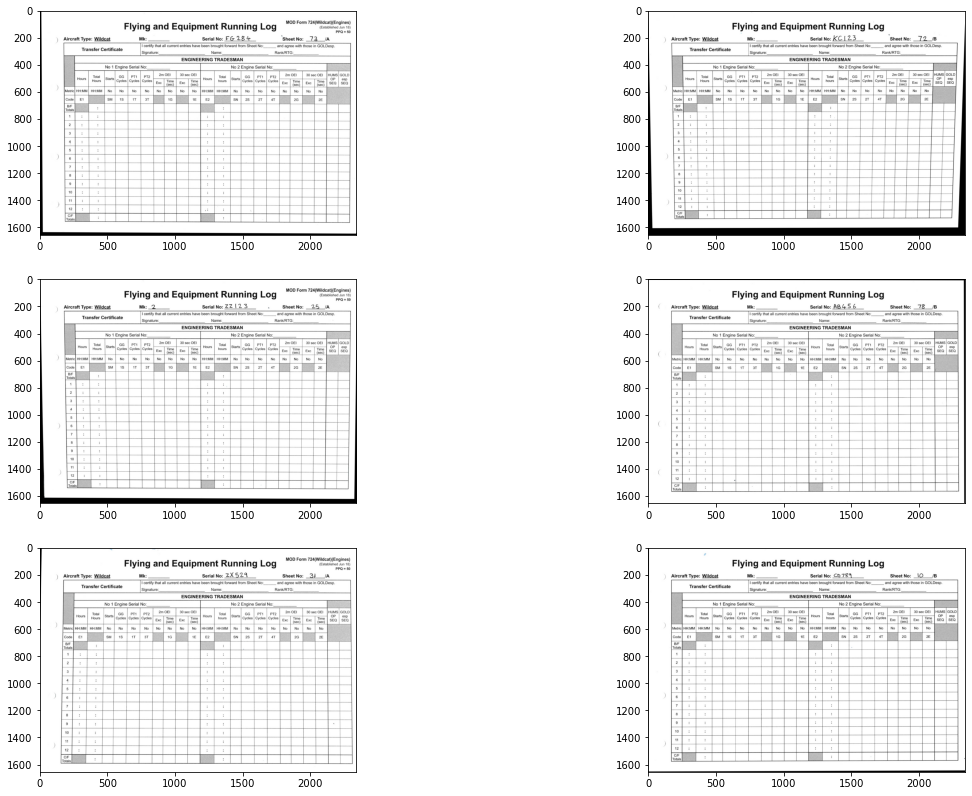

In [5]:
def align_images(image, template):
    #take both the input image and template then convert them to grayscale
    #this ensures the highest amount of accuracy
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    #using ORB extract and detect 500 features. getting 
    #keypoints and descriptors
    orb = cv2.ORB_create(500)
    (kpsA, descsA) = orb.detectAndCompute(imageGray, None)
    (kpsB, descsB) = orb.detectAndCompute(templateGray, None)

    #using bruteforce hamming get matches using the descriptors
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)
    matches = matcher.match(descsA, descsB, None)

    #sort returned matches by ecludian distance, with those of smaller distance
    #having higher similarity
    matches = sorted(matches, key=lambda x:x.distance)
    
    #drop the bottom 50% of matches,
    #leaving us with the best 250 matches
    keep = int(len(matches) * 0.5)
    matches = matches[:keep]

    # allocate memory for the keypoints (x,y-coordinates) from the
    # top matches -- we'll use these coordinates to compute our
    # homography matrix
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")

    #iterate through the remaining matches of descriptors, mapping
    #the keypoints against each other
    for (i, m) in enumerate(matches):
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt

    #using ransac calculate the homography matrix between the two images,
    #warping the input image to match the template
    (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
    (h, w) = template.shape[:2]
    oriented = cv2.warpPerspective(image, H, (w, h))

    #return the oriented image
    return oriented

#location of blank form
target_image = cv2.imread(r'C:\GitHub\mf724-ocr\mf724_images\724_Wildcat__Engines_.pdf1.jpg')

#empty list to store forms that have been oriented with homography
h_forms = []

#iterate through images of forms, using homography to orient them
for form in forms:
    aligned = align_images(form, target_image)
    h_forms.append(aligned)

#create empty figure to show results
fig = plt.figure(figsize=(20, 14))
rows = 3
columns = 2

#iterate through images, displaying them
for i, v in enumerate(h_forms):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(v)

### Output Files

In [6]:
for i, v in enumerate(h_forms):
    filename = r"C:\GitHub\mf724-ocr\ETL Documents\\" + str(i) + ".jpg"
    cv2.imwrite(filename, v)